In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import seaborn as sb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [82]:
dataset = pd.read_csv('youtubedata.csv',error_bad_lines=False)
#print(dataset.info())
print(dataset.shape)
dataset.head()


(2436, 4)


,VideoID,Title,Description,Class
0,13E5azGDK1k,FINE ART Music and Painting PEACEFUL SELECTION...,"<p class="""" id=""eow-description"">CALM MELODIES...",Art and Music
1,8XdHP_fQoB0,Beautiful Paintings + Beautiful Classical Music,"<p class="""" id=""eow-description"">Beautiful sel...",Art and Music
2,5mWjq2BsD9Q,Improvised Piano Music and Emotional Art Thera...,"<p class="""" id=""eow-description"">When watching...",Art and Music
3,tsKlRF2Gw1s,The Great Masterpieces of Art & Music,"<p class="""" id=""eow-description"">Skip the art ...",Art and Music
4,1b8xiXKd9Kk,"Art: music & painting - Van Gogh on Caggiano, ...","<p class="""" id=""eow-description"">♫ Buy “Art: M...",Art and Music


### Data Preprocessing

In [83]:

# Removing contents of tags and all for further text processing
dataset['Description'].replace(regex=True,inplace=True, to_replace= r'<.+?>', value=r' ')

# Removing links from all for further text processing
dataset['Description'].replace(regex=True,inplace=True, to_replace= r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', value=r' ')

# Replace email addresses
dataset['Description'].replace(regex=True,inplace=True, to_replace= r'^.+@[^\.].*\.[a-z]{2,}$', value=r'')

# Replace URLs with 'webaddress'
dataset['Description'].replace(regex=True,inplace=True, to_replace= r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', value=r'')

# Replace 10 digit phone numbers
dataset['Description'].replace(regex=True,inplace=True, to_replace= r'\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', value=r'')

# Replace numbers with 'numbr'
dataset['Description'].replace(regex=True,inplace=True, to_replace= r'\d+(\.\d+)?', value=r'')

# Remove punctuation
dataset['Description'].replace(regex=True,inplace=True, to_replace= r'[^\w\d\s]', value=r'')

#converting to lower case
dataset['Description'] = dataset['Description'].str.lower()
dataset['Title'] = dataset['Title'].str.lower()

# Removing non-english content
#dataset.drop(dataset[dataset.language!="english"].index,inplace=True)

# Removing rows with empty columns 
dataset.dropna(subset=['Description','Title','VideoID'],inplace=True)
print(dataset.shape)
print(dataset.info())
dataset.head()

(2436, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2436 entries, 0 to 2435
Data columns (total 4 columns):
VideoID        2436 non-null object
Title          2436 non-null object
Description    2436 non-null object
Class          2436 non-null object
dtypes: object(4)
memory usage: 95.2+ KB
None


,VideoID,Title,Description,Class
0,13E5azGDK1k,fine art music and painting peaceful selection...,calm melodies and beautiful pictures debussy ...,Art and Music
1,8XdHP_fQoB0,beautiful paintings + beautiful classical music,beautiful selected paintings combine with som...,Art and Music
2,5mWjq2BsD9Q,improvised piano music and emotional art thera...,when watching this special episode of the per...,Art and Music
3,tsKlRF2Gw1s,the great masterpieces of art & music,skip the art museum and come experience great...,Art and Music
4,1b8xiXKd9Kk,"art: music & painting - van gogh on caggiano, ...",buy art music amp painting van gogh on on c...,Art and Music


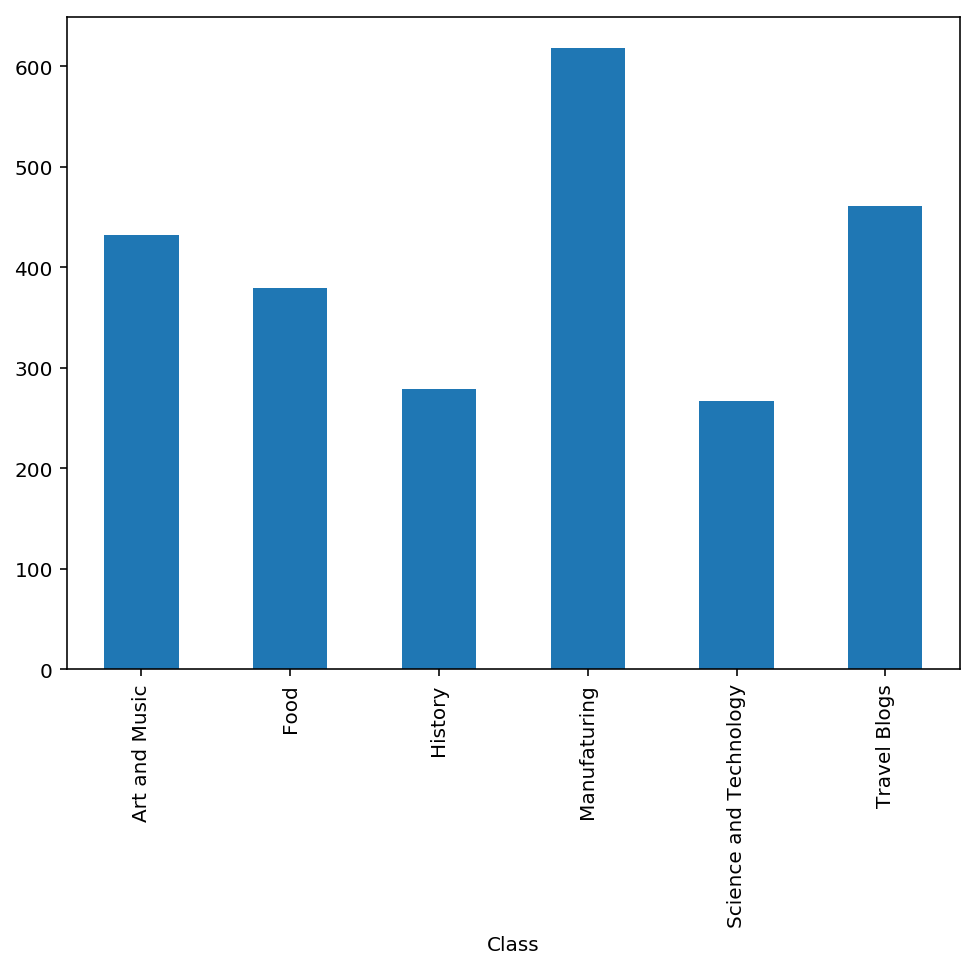

In [84]:
fig = plt.figure(figsize=(8,6))
dataset.groupby('Class').Title.count().plot.bar(ylim=0)
plt.show()

In [0]:

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dataset["Class"] = label.fit_transform(dataset["Class"])

### TFIDF VECTORIZER

In [86]:

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english')
Desc_features = tfidf.fit_transform(dataset.Description).toarray()
title_features = tfidf.fit_transform(dataset.Title).toarray() 
print(Desc_features.shape)
print(title_features.shape)
#print(tfidf.get_feature_names())
#print("/n/n/n")
#print(tfidf.vocabulary_)
#print(features)

(2436, 7828)
(2436, 633)


In [0]:
Y = dataset["Class"]

In [0]:
from sklearn.model_selection import train_test_split
X_title_train, X_title_test, y_title_train, y_title_test = train_test_split(title_features ,Y, test_size = 0.25, random_state=0)
X_Desc_train, X_Desc_test, y_Desc_train, y_Desc_test = train_test_split(Desc_features,Y, test_size = 0.25, random_state=0)

In [0]:
y_d_train = y_Desc_train.values
y_d_test = y_Desc_test.values
y_t_train = y_title_train.values
y_t_test = y_title_test.values

In [0]:
# Funtions to print confusion matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
def confusion_plot_desc(cm):
    ax= plt.subplot()
    sb.heatmap(cm, annot=True, ax = ax, cmap="Greens"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    labels = ['A', 'F','H','M', 'S','T']
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
    
def confusion_plot(cm):
    ax= plt.subplot()
    sb.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    labels = ['A', 'F','H','M', 'S','T']
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

    
# function to print Description report
def print_Desc_report(y_Desc_test, y_pred):
    print('Testing Accuracy Of Description: {}'.format(accuracy_score(y_Desc_test, y_pred)))
    print('Testing F1 score Of Description: {}'.format(f1_score(y_Desc_test, y_pred, average='weighted')))
    print(metrics.classification_report(y_Desc_test, y_pred))
    cm = metrics.confusion_matrix(y_Desc_test, y_pred)
    confusion_plot_desc(cm)
    print()

    
# function to print Title report    
def print_title_report(y_title_test, y_pred):
    print('Testing Accuracy of Title: {}'.format(accuracy_score(y_title_test, y_pred)))
    print('Testing F1 score of Title: {}'.format(f1_score(y_title_test, y_pred, average='weighted')))
    print(metrics.classification_report(y_title_test, y_pred))
    cmt = metrics.confusion_matrix(y_title_test, y_pred)
    confusion_plot(cmt)

    

### SVM Classifier

Testing Accuracy Of Description: 0.8555008210180624
Testing F1 score Of Description: 0.8561868045877725
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        96
           1       0.94      0.85      0.89       104
           2       0.90      0.77      0.83        73
           3       0.73      0.99      0.84       153
           4       0.94      0.74      0.83        66
           5       0.95      0.85      0.90       117

   micro avg       0.86      0.86      0.86       609
   macro avg       0.89      0.83      0.85       609
weighted avg       0.87      0.86      0.86       609




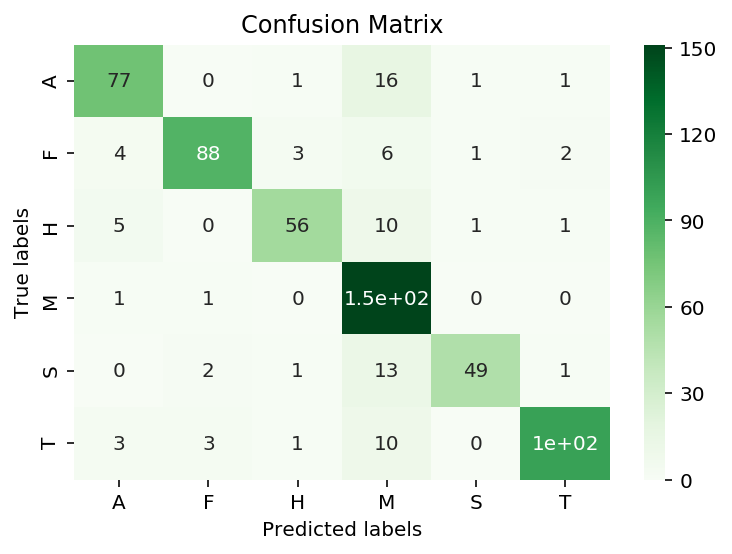

In [128]:
C = 1.0  
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn import svm

#Description
svc = svm.SVC(kernel='linear', C=C).fit(X_Desc_train, y_Desc_train)
y_pred= svc.predict(X_Desc_test)
print_Desc_report(y_Desc_test, y_pred)

Testing Accuracy of Title: 0.9802955665024631
Testing F1 score of Title: 0.9803530483609634
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       0.98      0.98      0.98       104
           2       1.00      0.96      0.98        73
           3       0.95      0.99      0.97       153
           4       1.00      0.98      0.99        66
           5       0.98      0.97      0.97       117

   micro avg       0.98      0.98      0.98       609
   macro avg       0.99      0.98      0.98       609
weighted avg       0.98      0.98      0.98       609



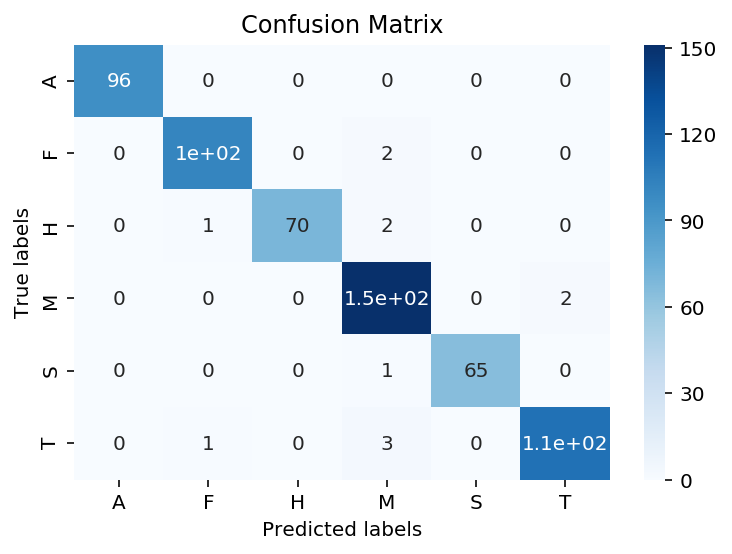

In [13]:
#Title
svc = svm.SVC(kernel='linear', C=C).fit(X_title_train, y_title_train)
y_predt= svc.predict(X_title_test)
print_title_report(y_title_test, y_predt)

### Naive Bayes

Testing Accuracy Of Description: 0.8555008210180624
Testing F1 score Of Description: 0.8561868045877725
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        96
           1       0.94      0.85      0.89       104
           2       0.90      0.77      0.83        73
           3       0.73      0.99      0.84       153
           4       0.94      0.74      0.83        66
           5       0.95      0.85      0.90       117

   micro avg       0.86      0.86      0.86       609
   macro avg       0.89      0.83      0.85       609
weighted avg       0.87      0.86      0.86       609




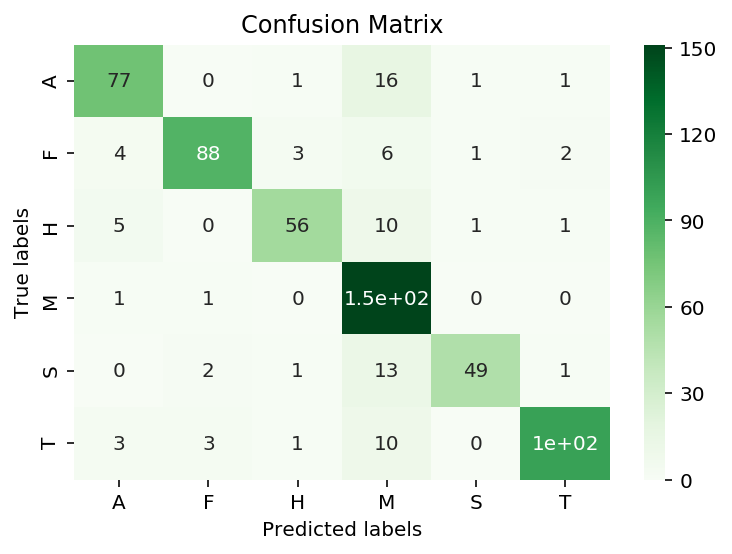

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
model = MultinomialNB()

# Description
model.fit(X_Desc_train, y_Desc_train)
predicted = model.predict(X_Desc_test)
print_Desc_report(y_Desc_test, y_pred)


Testing Accuracy of Title: 0.9622331691297209
Testing F1 score of Title: 0.9621574439644256
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        96
           1       0.97      0.94      0.96       104
           2       0.94      0.92      0.93        73
           3       0.94      0.97      0.95       153
           4       0.98      0.97      0.98        66
           5       0.97      0.97      0.97       117

   micro avg       0.96      0.96      0.96       609
   macro avg       0.96      0.96      0.96       609
weighted avg       0.96      0.96      0.96       609



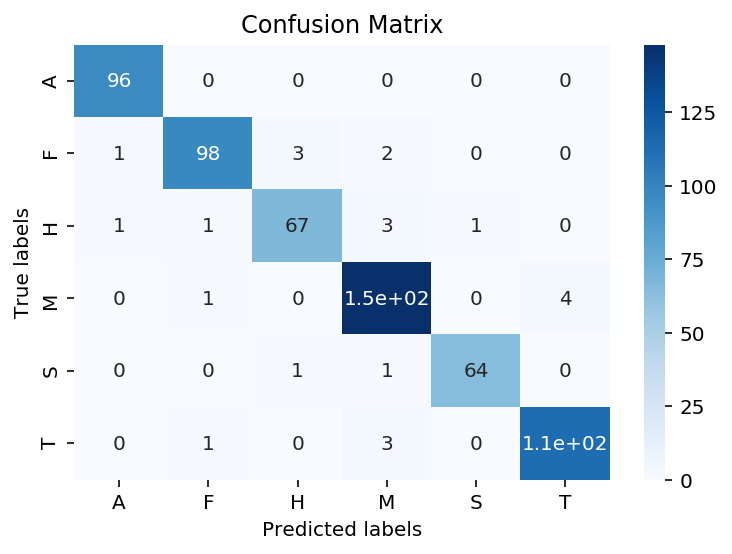

In [15]:
#Title
model.fit(X_title_train, y_title_train)
y_p= model.predict(X_title_test)
print_title_report(y_title_test, y_p)

### Random Forest Classifier

Testing Accuracy Of Description: 0.8653530377668309
Testing F1 score Of Description: 0.8674635283463541
              precision    recall  f1-score   support

           0       0.69      0.94      0.79        96
           1       0.91      0.86      0.88       104
           2       0.98      0.77      0.86        73
           3       0.86      0.92      0.89       153
           4       0.98      0.77      0.86        66
           5       0.93      0.86      0.89       117

   micro avg       0.87      0.87      0.87       609
   macro avg       0.89      0.85      0.86       609
weighted avg       0.88      0.87      0.87       609




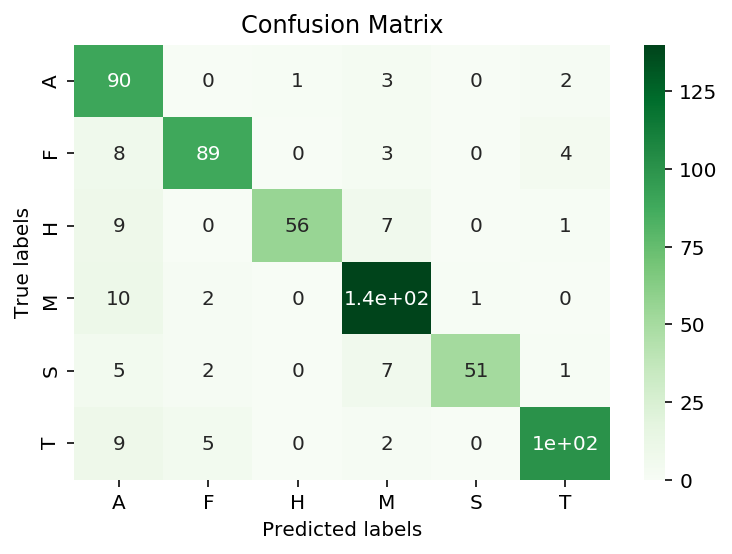

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model = RandomForestClassifier(n_estimators=100,n_jobs=3)

#Description
model.fit(X_Desc_train, y_Desc_train)
y_pred_rfc = model.predict(X_Desc_test)
print_Desc_report(y_Desc_test, y_pred_rfc)


Testing Accuracy of Title: 0.8522167487684729
Testing F1 score of Title: 0.8541247111973579
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        96
           1       0.88      0.84      0.86       104
           2       0.95      0.77      0.85        73
           3       0.71      0.97      0.82       153
           4       0.96      0.77      0.86        66
           5       0.93      0.85      0.89       117

   micro avg       0.85      0.85      0.85       609
   macro avg       0.90      0.83      0.86       609
weighted avg       0.87      0.85      0.85       609



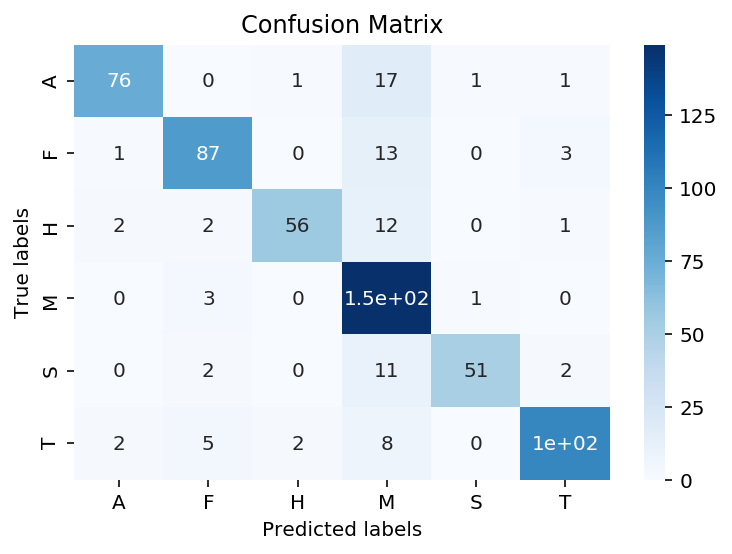

In [58]:
#Title
model.fit(X_title_train, y_title_train)
y_pred_ = model.predict(X_title_test)
y_pred_= svc.predict(X_title_test)
print_title_report(y_title_test, y_pred)


### XgBoost

Testing Accuracy Of Description: 0.8522167487684729
Testing F1 score Of Description: 0.8541247111973579
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        96
           1       0.88      0.84      0.86       104
           2       0.95      0.77      0.85        73
           3       0.71      0.97      0.82       153
           4       0.96      0.77      0.86        66
           5       0.93      0.85      0.89       117

   micro avg       0.85      0.85      0.85       609
   macro avg       0.90      0.83      0.86       609
weighted avg       0.87      0.85      0.85       609




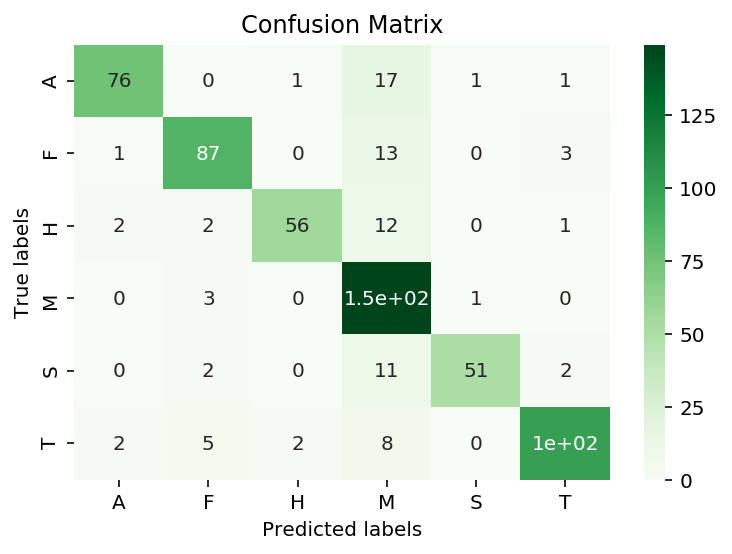

In [18]:
from xgboost import XGBClassifier
from sklearn import metrics

#Description
model = XGBClassifier()
model.fit(X_Desc_train, y_Desc_train)
y_pred = model.predict(X_Desc_test)
print_Desc_report(y_Desc_test, y_pred)


Testing Accuracy of Title: 0.8522167487684729
Testing F1 score of Title: 0.8541247111973579
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        96
           1       0.88      0.84      0.86       104
           2       0.95      0.77      0.85        73
           3       0.71      0.97      0.82       153
           4       0.96      0.77      0.86        66
           5       0.93      0.85      0.89       117

   micro avg       0.85      0.85      0.85       609
   macro avg       0.90      0.83      0.86       609
weighted avg       0.87      0.85      0.85       609



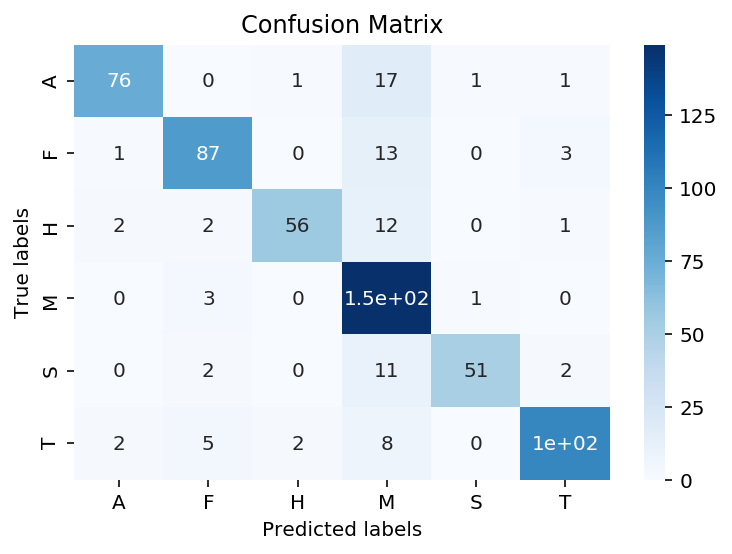

In [19]:

# Title
model.fit(X_title_train, y_title_train)
y_pred_ = model.predict(X_title_test)
y_pred_= svc.predict(X_title_test)
print_title_report(y_title_test, y_pred)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [0]:
# Initialiation
classifier = Sequential()

In [130]:
# Adding layer
classifier.add(Dense(output_dim =4000 ,init = "uniform", activation = "relu", input_dim = 7828))
classifier.add(Dense(output_dim = 1000,init = "uniform", activation = "relu" ))
classifier.add(Dense(output_dim = 1000,init = "uniform", activation = "relu" ))
classifier.add(Dense(output_dim = 500,init = "uniform", activation = "relu" ))
classifier.add(Dense(output_dim = 100,init = "uniform", activation = "relu" ))
classifier.add(Dense(output_dim = 6,init = "uniform", activation = "softmax" ))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=7828, units=4000, kernel_initializer="uniform")`
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=1000, kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=1000, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=500, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykern

In [0]:
#compiling the Neural Network
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
from keras.utils import to_categorical
y_d_train = to_categorical(y_d_train)
y_d_test = to_categorical(y_d_test)
y_t_train = to_categorical(y_t_train)
y_t_test = to_categorical(y_t_test)

In [136]:
classifier.fit(X_Desc_train, y_d_train, batch_size = 10,epochs = 15)

Epoch 1/15
1827/1827 [==============================] - 107s 59ms/step - loss: 1.1867 - acc: 0.5167
Epoch 2/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.4466 - acc: 0.8435
Epoch 3/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.2832 - acc: 0.9179
Epoch 4/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.1326 - acc: 0.9485
Epoch 5/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.1096 - acc: 0.9611
Epoch 6/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.0981 - acc: 0.9628
Epoch 7/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.0761 - acc: 0.9666
Epoch 8/15
1827/1827 [==============================] - 102s 56ms/step - loss: 0.0788 - acc: 0.9666
Epoch 9/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.0855 - acc: 0.9683
Epoch 10/15
1827/1827 [==============================] - 103s 56ms/step - loss: 0.0781 - acc: 0.9693

In [140]:
y_pred = classifier.predict(X_Desc_test)
print(y_pred)

[[9.3433127e-06 9.9898475e-01 6.9492198e-05 7.1759854e-04 7.8831345e-06
  2.1085994e-04]
 [6.6240758e-19 2.9856339e-13 2.0167833e-15 1.0385745e-12 6.2525484e-22
  1.0000000e+00]
 [5.5215327e-13 2.3258114e-18 1.5791968e-16 1.0000000e+00 6.3508614e-16
  2.7679185e-14]
 ...
 [2.4454146e-15 1.2088201e-21 1.8238580e-19 1.0000000e+00 7.1062973e-19
  9.0740668e-17]
 [1.0000000e+00 2.2814692e-34 9.9691326e-27 0.0000000e+00 0.0000000e+00
  0.0000000e+00]
 [8.1753378e-26 5.3587378e-18 5.3598335e-21 2.8198643e-17 5.6719163e-30
  1.0000000e+00]]
